# 链接图生图管道

图生图的 Pipeline，可以与其他 pipeline 链接起来。

## 文生图生图

通过链接文本到图像和图像到图像管道，您可以从文本生成图像，并将生成的图像用作图像到图像管道的初始图像。

先执行文生图，使用 stable diffusion 1.5。

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

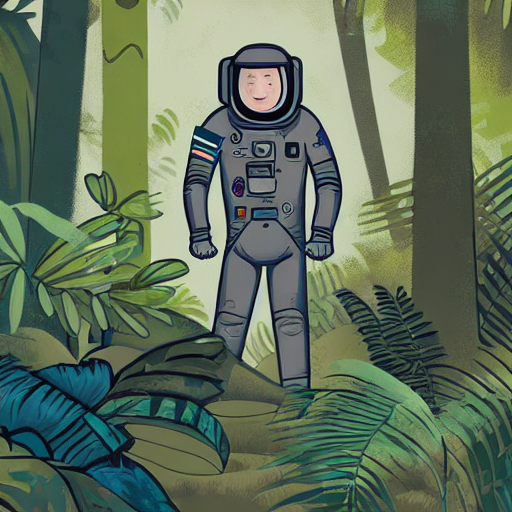

In [1]:
from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image
import torch
from diffusers.utils import make_image_grid

model_path="/models/stable-diffusion-v1-5"

pipeline = AutoPipelineForText2Image.from_pretrained(
    model_path, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

generator = torch.Generator(device="cuda").manual_seed(111000112)
text2image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",generator=generator).images[0]
text2image

In [ ]:
再执行图生图，使用 kandinsky 2.2

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

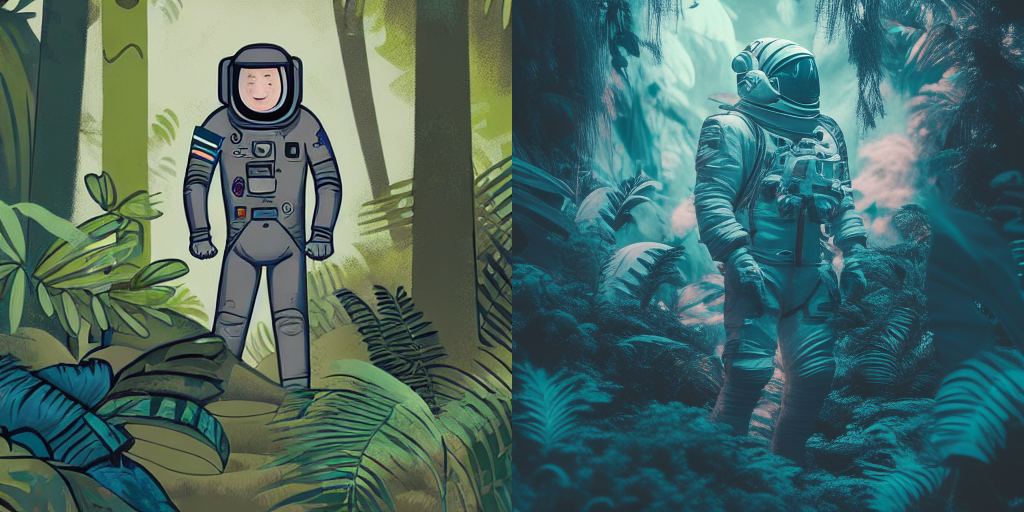

In [4]:
import sys,os,os.path
os.environ['http_proxy']="http://192.168.0.133:7890"
os.environ['https_proxy']="http://192.168.0.133:7890"
os.environ['all_proxy']="http://192.168.0.133:7890"

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

generator = torch.Generator(device="cuda").manual_seed(10086)

image2image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", image=text2image,
                       generator=generator).images[0]
make_image_grid([text2image, image2image], rows=1, cols=2)

## 图生图生图

可以将多个图像到图像管道链接在一起以创建更有趣的图像。

这对于在图像上迭代执行样式转换、生成短 GIF、恢复图像颜色或恢复图像的缺失区域非常有用。

生成第一个图。

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

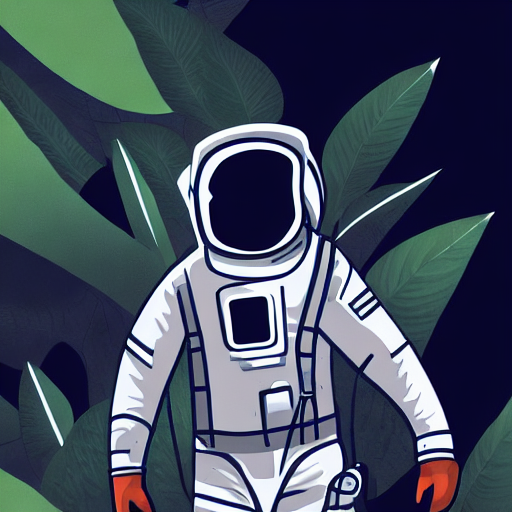

In [6]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

sd_model_path="/models/stable-diffusion-v1-5"

pipeline = AutoPipelineForImage2Image.from_pretrained(
    sd_model_path, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

# prepare image
url = "./img2img-init.png"
init_image = load_image(url)

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

generator = torch.Generator(device="cuda").manual_seed(12345)
image = pipeline(prompt, image=init_image, output_type="latent",generator=generator).images[0]

image2 = pipeline(prompt, image=init_image,generator=generator).images[0]
image2


## 生成图的放大

使用 upscaler 和 super-resolution 管道来真正提高图像的细节水平。